In [2]:
!pip install statsmodels

     |████████████████████████████████| 9.9 MB 8.3 MB/s eta 0:00:01
     |████████████████████████████████| 233 kB 6.5 MB/s eta 0:00:01


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import os
import matplotlib.pyplot as plt

from scipy.stats import ks_2samp
from statsmodels.distributions.empirical_distribution import ECDF

In [4]:
plt.rcParams['figure.figsize']  = (3.33, 5.5)
plt.rcParams['axes.labelsize']  = 16
plt.rcParams['axes.titlesize']  = 18
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 3

In [5]:
df_downloads_desc = pd.read_csv("../data/download_descriptions.csv")

input_path = "../data/03_scored/without_inputation/severe_toxicity/"
output_path = "../data/imgs"

bins = np.linspace(0, 1, num=20)

---

### Toxicity Score Cumulative Distribution Function (CDF)

Group: `White Man` had 48 reading problems
Group: `Black Man` had 23 reading problems
Group: `White Woman` had 9 reading problems
Group: `Black Woman` had 3 reading problems


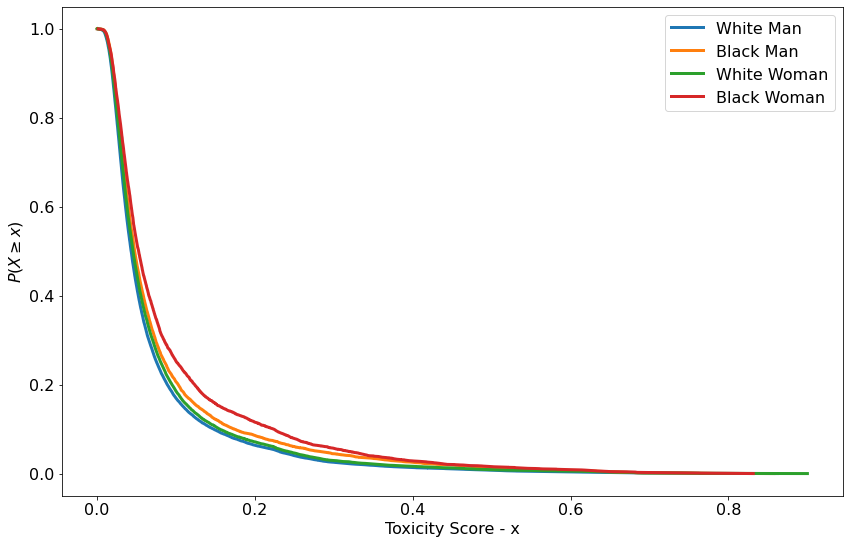

In [6]:
plt.subplots(figsize=(14,9))

for group in df_downloads_desc["group"].unique():
    group_urls = df_downloads_desc[df_downloads_desc.group == group]    
    filenames = [row["url"].split("v=")[1].split("&")[0] for _, row in group_urls.iterrows()]
    
    dfs = []
    count = 0
    for filename in filenames:
        try:
            dfs.append(pd.read_csv(os.path.join(input_path, filename)))
        except:
            count += 1
    
    print(f"Group: `{group}` had {count} reading problems")
    
    df = pd.concat(dfs)
    del dfs
    
    ecdf = ECDF(df.score)
    plt.plot(ecdf.x, 1-ecdf.y, label=group)

plt.xlabel("Toxicity Score - x")
plt.ylabel(r"$P(X \geq x)$")
plt.legend()

plt.savefig(os.path.join(output_path, "inverse_cdf.pdf"))
plt.show()

---

### Toxicity Score Distribution

Group: `White Man` had 48 reading problems
Group: `Black Man` had 23 reading problems
Group: `White Woman` had 9 reading problems
Group: `Black Woman` had 3 reading problems


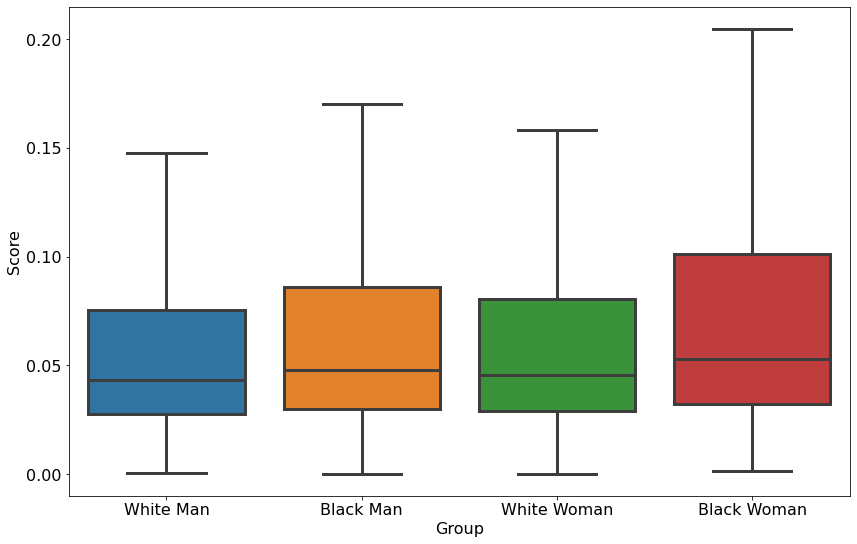

In [7]:
plt.subplots(figsize=(14,9))

dfs = []
for group in df_downloads_desc["group"].unique():
    group_urls = df_downloads_desc[df_downloads_desc.group == group]    
    filenames = [row["url"].split("v=")[1].split("&")[0] for _, row in group_urls.iterrows()]
    
    df_group = []
    count = 0
    for filename in filenames:
        try:
            df_group.append(pd.read_csv(os.path.join(input_path, filename)))
        except:
            count += 1
    
    print(f"Group: `{group}` had {count} reading problems")
    
    df_group = pd.concat(df_group)
    df_group["group"] = group
    
    dfs.append(df_group)

df = pd.concat(dfs)
del dfs, df_group

sns.boxplot(data=df, x="group", y="score", showfliers=False)
plt.xlabel("Group")
plt.ylabel("Score")

plt.savefig(os.path.join(output_path, "group_distribution.pdf"))
plt.show()

---

### Two-Sample Kolmogorov-Smirnov's Test

In [8]:
ks_all = []
groups = df.group.unique()
for first_group in groups:
    ks_one_vs_all = []
    for second_group in groups:
        statistic, p_value = ks_2samp(
            df[df.group == first_group].score,
            df[df.group == second_group].score
        )
        
        ks_one_vs_all.append(
            f"{np.abs(np.round(statistic*100, 3))} ({np.round(p_value*100, 3)})"
        )
    ks_all.append(ks_one_vs_all)

In [9]:
pd.DataFrame(ks_all, columns=groups, index=groups)

,White Man,Black Man,White Woman,Black Woman
White Man,0.0 (100.0),5.656 (0.0),3.156 (0.0),10.502 (0.0)
Black Man,5.656 (0.0),0.0 (100.0),2.757 (0.032),5.373 (0.0)
White Woman,3.156 (0.0),2.757 (0.032),0.0 (100.0),7.63 (0.0)
Black Woman,10.502 (0.0),5.373 (0.0),7.63 (0.0),0.0 (100.0)
